In [1]:
!pip install kneed

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from scipy.signal import savgol_filter

import lightgbm as lgb
from kneed import KneeLocator

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)
# Input data files are available i

import datetime

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



In [3]:
def MinMaxScaler(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))

def Kmeans_clustering(df, clusterNum, max_iter=1000, n_jobs=-1):
    '''
    Function for doing kmeans clustering.
    Inputs should include at least the dataframe of variables and cluster number you want.
    '''
    # Normalize the dataframe
    scaler = StandardScaler()
    scaler.fit(df) 
    df_std = pd.DataFrame(data=scaler.transform(df), columns=df.columns, index=df.index)
    
    # Kmeans clustering
    km_model = KMeans(n_clusters=clusterNum, max_iter=max_iter, random_state=666)
    km_model = km_model.fit(df_std)
    
    clusterdf= pd.DataFrame(data=km_model.labels_, columns=['ClusterNo'])
    clusterdf.index = df.index
    
    return clusterdf

def Kmeans_bestClusterNum(df, range_min, range_max, max_iter=1000, n_jobs=-1):
    '''
    Function for finding optimal number of kmeans clustering.
    Inputs should include at least the dataframe of variables, and search range of cluster number (min & max cluster number).
    '''    
    
    # Normalize the dataframe
    scaler = StandardScaler()
    scaler.fit(df) 
    df_std = pd.DataFrame(data=scaler.transform(df), columns=df.columns, index=df.index)       
    
    # Calculate inertia for each cluster number in the research range
    sum_of_squared_distances = [] #Inertia of all clustering results
    ks = range(range_min,range_max+1)
    for k in ks:
        kmeans_fit = KMeans(n_clusters = k, max_iter=max_iter, random_state=666).fit(df_std)
        cluster_labels = kmeans_fit.labels_
        sum_of_squared_distances.append(kmeans_fit.inertia_)
        
    # Use kneed package to locate the elbow / knee of the curve line
    kn = KneeLocator(list(ks), sum_of_squared_distances, S=1.0, curve='convex', direction='decreasing')  
    
    # Plot the result of finding optimal cluster number
    plt.xlabel('k')
    plt.ylabel('sum_of_squared_distances')
    plt.title('The Elbow Method showing the optimal k')
    plt.plot(ks, sum_of_squared_distances, 'bx-')
    plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    plt.show()
    
    print('Optimal clustering number:'+str(kn.knee))
    print('----------------------------')    
    
    return kn.knee

In [4]:
train_features = pd.read_csv('../input/energy-anomaly-detection/train_features.csv')
train_features['cloud_coverage'] = train_features['cloud_coverage'].replace({255:10})

In [5]:
test_features = pd.read_csv('../input/energy-anomaly-detection/test_features.csv', index_col=0)
test_features['cloud_coverage'] = test_features['cloud_coverage'].replace({255:10})

In [6]:
merged_data = pd.concat([train_features, test_features],axis=0,ignore_index=True)
merged_data_pivot = merged_data.pivot_table(index='timestamp',columns='building_id',values='meter_reading')

# remove outliers (10 std away from avg)
merged_data_pivot = (merged_data_pivot-merged_data_pivot.mean())/merged_data_pivot.std()
merged_data_pivot = merged_data_pivot[merged_data_pivot<10]
merged_data_pivot = merged_data_pivot[merged_data_pivot>-10]

merged_data_pivot = (merged_data_pivot-merged_data_pivot.mean())/merged_data_pivot.std()
merged_data_pivot = merged_data_pivot[merged_data_pivot<10]
merged_data_pivot = merged_data_pivot[merged_data_pivot>-10]

merged_data_pivot.index = pd.to_datetime(merged_data_pivot.index)

merged_data_pivot

building_id,1,18,19,26,32,38,39,41,55,69,...,1317,1318,1319,1320,1321,1322,1323,1353,1384,1425
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.782113,-1.222397,-0.295801,-0.724083,-0.491904,-0.581884,-0.121795,-0.855589,-0.896302,-1.086031
2016-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.785629,-1.379572,-0.590580,-0.723904,-0.612916,-0.824660,-0.050955,-0.835054,-0.896302,-1.055597
2016-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.797065,-1.222410,-1.180016,-0.872948,-0.722403,-0.750251,-0.121795,-0.848744,-0.735114,-1.021960
2016-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.808502,-1.052165,-0.590580,-0.415254,-0.676303,-0.562336,-0.357927,-0.876124,-1.218678,-1.102049
2016-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.860365,-1.248604,-0.885310,-1.071047,-0.710878,-0.280418,-1.042711,-0.828209,-1.702243,-1.014752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,-2.118043,0.296662,-1.094677,2.117905,0.668420,1.096717,-0.195342,1.026779,0.278385,0.808463,...,-1.077512,0.337358,NaN,-0.760755,4.100800,-0.246380,-0.145408,-1.259441,-2.024620,-0.896621
2016-12-31 20:00:00,-2.762260,0.194716,-0.946744,1.932770,-0.592391,1.087021,-0.170175,1.038128,0.658975,0.800188,...,-1.040601,0.304288,NaN,-0.746354,3.132702,-0.224326,-0.287087,-1.252596,-1.863431,-1.014352
2016-12-31 21:00:00,-2.717712,0.105477,-1.346097,2.148752,-1.082701,1.016505,-0.226799,1.032404,0.844583,0.816739,...,-1.394012,0.345019,NaN,-1.009660,2.700515,-0.709104,-0.074568,-1.259441,-1.702243,-0.979914


In [7]:
merged_data_pivot = np.log1p(merged_data_pivot)

In [8]:
df_PM_temp = merged_data_pivot.copy()
df_PM_temp = df_PM_temp.T

bestClusterNum_dept = 10
#bestClusterNum_dept = Kmeans_bestClusterNum(df=df_PM_temp.fillna(0), range_min=2, range_max=30, max_iter=10000, n_jobs=-1)

Cluster No.: 0
Amount of meters: 26


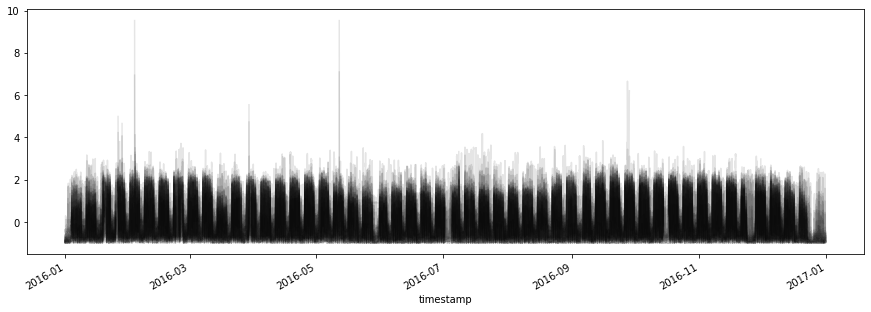

-----------------------------------------------------------------------------------
Cluster No.: 1
Amount of meters: 20


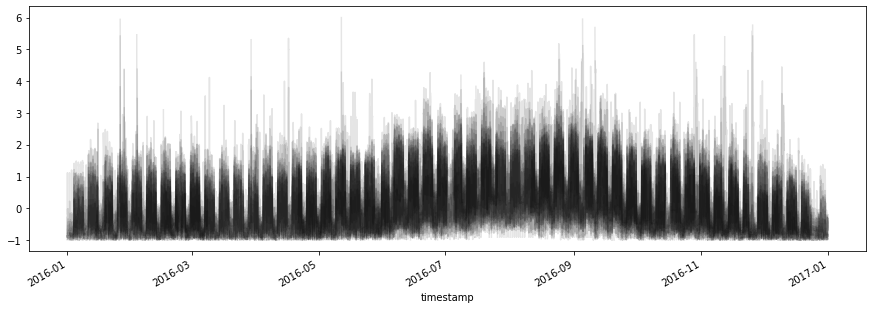

-----------------------------------------------------------------------------------
Cluster No.: 2
Amount of meters: 21


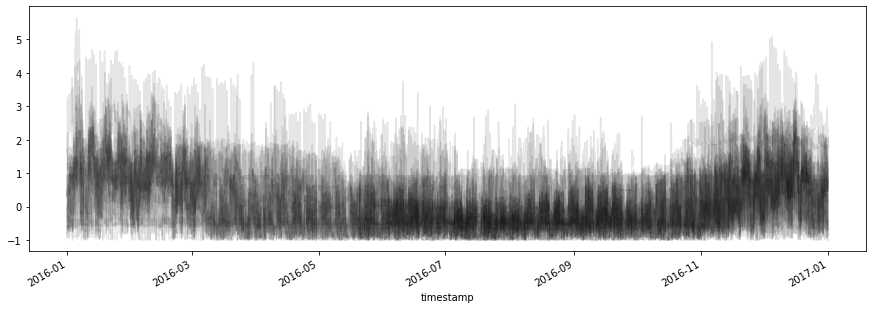

-----------------------------------------------------------------------------------
Cluster No.: 3
Amount of meters: 71


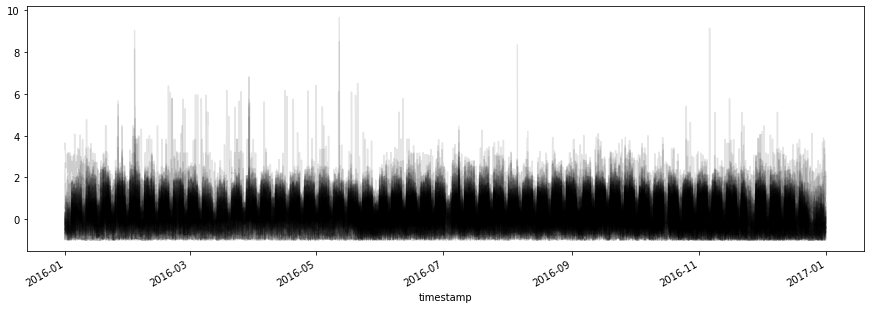

-----------------------------------------------------------------------------------
Cluster No.: 4
Amount of meters: 63


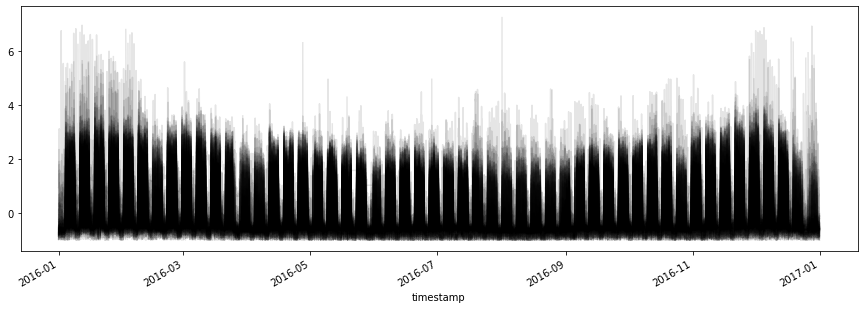

-----------------------------------------------------------------------------------
Cluster No.: 5
Amount of meters: 16


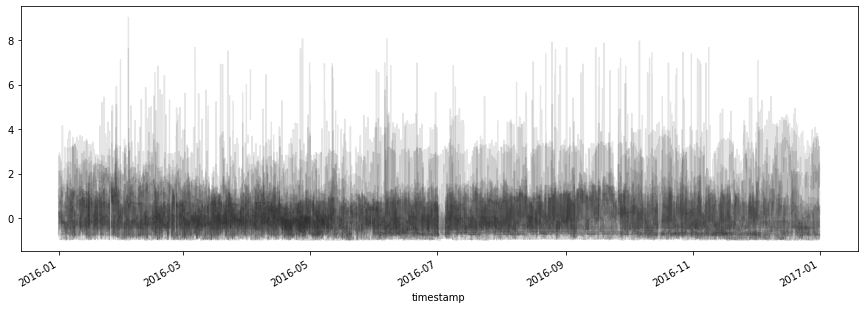

-----------------------------------------------------------------------------------
Cluster No.: 6
Amount of meters: 73


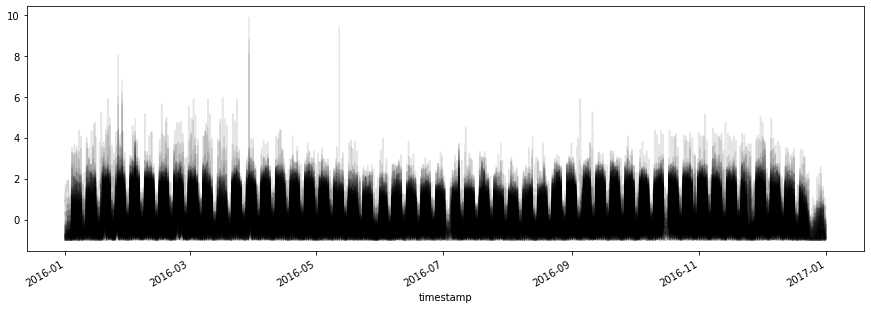

-----------------------------------------------------------------------------------
Cluster No.: 7
Amount of meters: 24


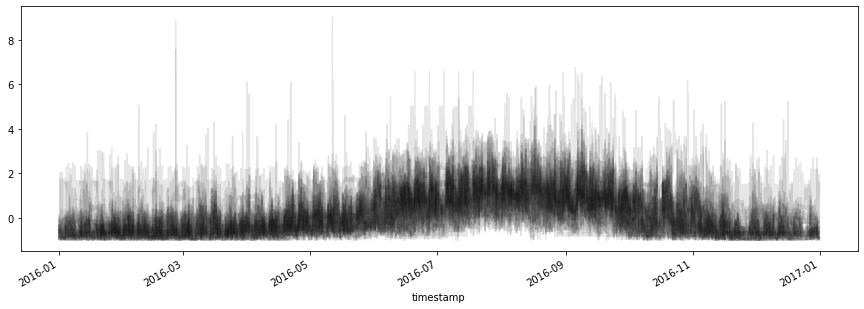

-----------------------------------------------------------------------------------
Cluster No.: 8
Amount of meters: 67


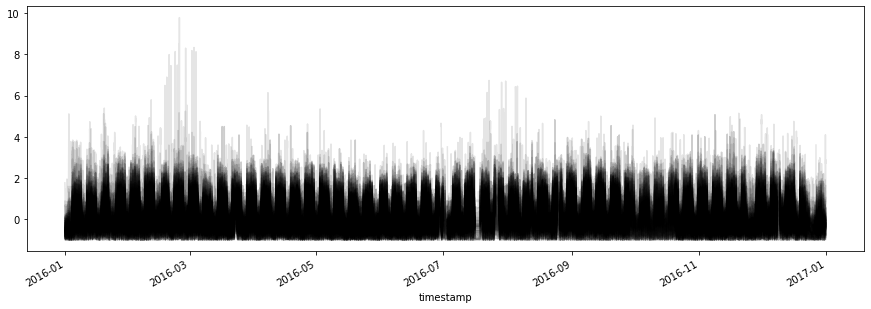

-----------------------------------------------------------------------------------
Cluster No.: 9
Amount of meters: 25


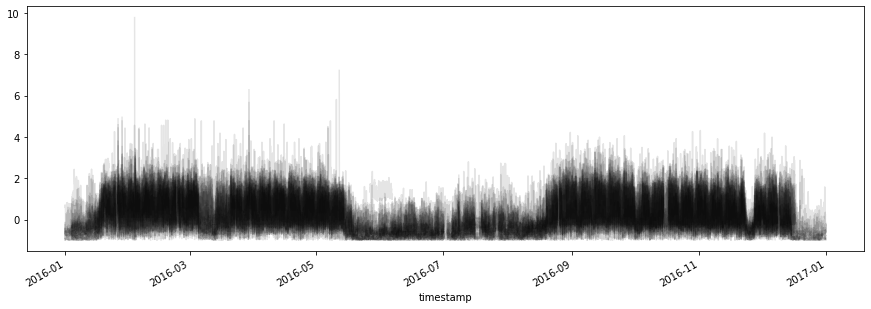

-----------------------------------------------------------------------------------


In [9]:
df_PM_temp['ClusterNo'] = Kmeans_clustering(df=df_PM_temp.fillna(0), clusterNum=bestClusterNum_dept, max_iter=10000, n_jobs=-1)

for ClusterNo in df_PM_temp['ClusterNo'].sort_values().unique():
    df_plot = df_PM_temp[df_PM_temp['ClusterNo']==ClusterNo].T.drop('ClusterNo')
    df_plot = np.expm1(df_plot)
    print('Cluster No.: ' + str(ClusterNo))    
    print('Amount of meters: ' + str(len(df_plot.T)))
    df_plot.plot(figsize=(15,5),color='black',alpha=0.1,legend=False)
    plt.show()
    print('-----------------------------------------------------------------------------------')

In [10]:
test_features = test_features.merge(df_PM_temp['ClusterNo'].reset_index(),on='building_id',how='left')

In [11]:
def impute_nulls(data):
    mean_reading = data.groupby('building_id').mean()['meter_reading']

    building_id = mean_reading.index
    values = mean_reading.values
    
    for i, idx in tqdm(enumerate(building_id)):
        data[data['building_id']==idx] = data[data['building_id']==idx].fillna(values[i]) 
    
    return data

#train_features = impute_nulls(train_features)
test_features = impute_nulls(test_features)

206it [04:28,  1.31s/it]


In [12]:
#value change features(diff)
test_feature = pd.read_csv('../input/energy-anomaly-detection/test_features.csv')
for shift_hours in tqdm(list(np.arange(-24,0))+list(np.arange(1,24+1))+list(np.arange(-24*7,-24,24))+list(np.arange(24+24,24*7+1,24))):
    shift_hours = int(shift_hours)
    meter_reading_shift = test_feature[['building_id', 'timestamp', 'meter_reading']]
    meter_reading_shift['timestamp'] = pd.to_datetime(meter_reading_shift['timestamp']) + datetime.timedelta(hours=shift_hours)
    meter_reading_shift['timestamp'] = meter_reading_shift['timestamp'].astype('str')
    meter_reading_shift = meter_reading_shift.rename(columns={'meter_reading':'lag_value_'+str(shift_hours)})
    test_feature = test_feature.merge(meter_reading_shift, on=['building_id', 'timestamp'], how='left')
    
    test_features['lag_value_'+str(shift_hours)] = test_feature['lag_value_'+str(shift_hours)]-test_feature['meter_reading']

100%|██████████| 60/60 [15:17<00:00, 15.28s/it]


In [13]:
#value change features(ratio)
test_feature = pd.read_csv('../input/energy-anomaly-detection/test_features.csv')
for shift_hours in tqdm(list(np.arange(-24,0))+list(np.arange(1,24+1))+list(np.arange(-24*7,-24,24))+list(np.arange(24+24,24*7+1,24))):
    shift_hours = int(shift_hours)
    meter_reading_shift = test_feature[['building_id', 'timestamp', 'meter_reading']]
    meter_reading_shift['timestamp'] = pd.to_datetime(meter_reading_shift['timestamp']) + datetime.timedelta(hours=shift_hours)
    meter_reading_shift['timestamp'] = meter_reading_shift['timestamp'].astype('str')
    meter_reading_shift = meter_reading_shift.rename(columns={'meter_reading':'lag_value_'+str(shift_hours)})
    test_feature = test_feature.merge(meter_reading_shift, on=['building_id', 'timestamp'], how='left')
    
    test_features['lag_value_ratio_'+str(shift_hours)] = (test_feature['lag_value_'+str(shift_hours)]+1)/(test_feature['meter_reading']+1)

100%|██████████| 60/60 [13:32<00:00, 13.54s/it]


In [16]:
df_savgol_test = []

for building_id in tqdm(test_features['building_id'].unique()):
    df_temp = test_features[test_features['building_id']==building_id]
    df_temp['meter_reading_smooth'] = savgol_filter(df_temp['meter_reading'].fillna(method='ffill'), 5, 3)
    df_temp['Residual_savgol_w5p3'] = (df_temp['meter_reading'] - df_temp['meter_reading_smooth'])
    df_savgol_test.append(df_temp)
    
df_savgol_test = pd.concat(df_savgol_test,axis=0).sort_index()
df_savgol_test

100%|██████████| 206/206 [00:10<00:00, 18.74it/s]


,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,lag_value_ratio_-72,lag_value_ratio_-48,lag_value_ratio_48,lag_value_ratio_72,lag_value_ratio_96,lag_value_ratio_120,lag_value_ratio_144,lag_value_ratio_168,meter_reading_smooth,Residual_savgol_w5p3
0,18,2016-01-01 00:00:00,594.902165,0,Education,111891,96,0,19.4,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,594.902165,1.136868e-13
1,19,2016-01-01 00:00:00,60.181135,0,Office,18717,104,0,19.4,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.181135,6.394885e-14
2,26,2016-01-01 00:00:00,47.831186,0,Office,26953,105,0,19.4,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.831186,1.421085e-14
3,38,2016-01-01 00:00:00,143.504764,0,Office,12769,113,0,19.4,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.504764,0.000000e+00
4,39,2016-01-01 00:00:00,98.132823,0,Office,64619,69,0,19.4,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.132823,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800562,1320,2016-12-31 23:00:00,74.552000,14,Entertainment/public assembly,34565,255,0,-29.9,10,...,NaN,NaN,1.341778,1.343035,1.693165,1.158010,1.013024,0.999841,75.227471,-6.754714e-01
1800563,1321,2016-12-31 23:00:00,584.000000,14,Entertainment/public assembly,370024,255,0,-29.9,10,...,NaN,NaN,1.454701,1.454701,0.900855,0.921368,0.834188,0.497436,591.214286,-7.214286e+00
1800564,1322,2016-12-31 23:00:00,131.596000,14,Entertainment/public assembly,166489,255,0,-29.9,10,...,NaN,NaN,0.962299,0.921053,0.869627,0.921053,0.937140,0.853540,132.624400,-1.028400e+00
1800565,1384,2016-12-31 23:00:00,1.200000,15,Education,56969,67,0,-29.9,10,...,NaN,NaN,1.000000,1.022727,1.000000,1.034091,1.011364,0.875000,1.201786,-1.785714e-03


In [17]:
test_features['Residual_savgol_w5p3'] = df_savgol_test['Residual_savgol_w5p3']

In [19]:
test_features.to_pickle('test_features.pickle')
test_features

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,lag_value_ratio_-96,lag_value_ratio_-72,lag_value_ratio_-48,lag_value_ratio_48,lag_value_ratio_72,lag_value_ratio_96,lag_value_ratio_120,lag_value_ratio_144,lag_value_ratio_168,Residual_savgol_w5p3
0,18,2016-01-01 00:00:00,594.902165,0,Education,111891,96,0,19.4,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.136868e-13
1,19,2016-01-01 00:00:00,60.181135,0,Office,18717,104,0,19.4,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.394885e-14
2,26,2016-01-01 00:00:00,47.831186,0,Office,26953,105,0,19.4,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.421085e-14
3,38,2016-01-01 00:00:00,143.504764,0,Office,12769,113,0,19.4,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
4,39,2016-01-01 00:00:00,98.132823,0,Office,64619,69,0,19.4,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800562,1320,2016-12-31 23:00:00,74.552000,14,Entertainment/public assembly,34565,255,0,-29.9,10,...,NaN,NaN,NaN,1.341778,1.343035,1.693165,1.158010,1.013024,0.999841,-6.754714e-01
1800563,1321,2016-12-31 23:00:00,584.000000,14,Entertainment/public assembly,370024,255,0,-29.9,10,...,NaN,NaN,NaN,1.454701,1.454701,0.900855,0.921368,0.834188,0.497436,-7.214286e+00
1800564,1322,2016-12-31 23:00:00,131.596000,14,Entertainment/public assembly,166489,255,0,-29.9,10,...,NaN,NaN,NaN,0.962299,0.921053,0.869627,0.921053,0.937140,0.853540,-1.028400e+00
1800565,1384,2016-12-31 23:00:00,1.200000,15,Education,56969,67,0,-29.9,10,...,NaN,NaN,NaN,1.000000,1.022727,1.000000,1.034091,1.011364,0.875000,-1.785714e-03
